In [144]:
import face_recognition
import os
import pandas as pd
import numpy as np
import pickle
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from scikit_checkpoint import ScikitCheckpoint
from sklearn.cluster import KMeans
from PIL import Image
%matplotlib inline
from matplotlib.pyplot import imshow
np.random.seed(4)

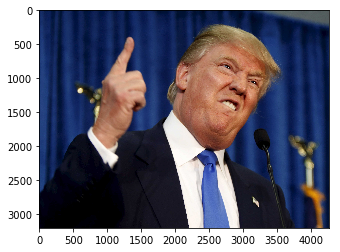

In [145]:
## Load original image

image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image.jpg')

image = face_recognition.load_image_file(image_path)
imgplot = imshow(image)

A face is located at pixel location Top: 430, Left: 2270, Bottom: 1810, Right: 3650


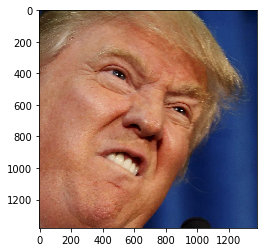

In [146]:
## Facial Detection
face_locations = face_recognition.face_locations(image)
len(face_locations)
for face_location in face_locations:
    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    imgplot = imshow(face_image)


In [147]:
import json
with open(os.environ['INPUT_DIR']+'/config.json') as f:
     config = json.load(f)

class_names = config['class_names']
print class_names

[u'other', u'donald_trump']


In [148]:
data = []
target = []
face_names = []
num_faces = len(face_names)
# Training load data
faces_selected = set()
for file_path in glob(os.environ.get("DATA_DIR")+"/*/*"):
    class_name = file_path.split('/')[-2]
    if class_name in class_names and class_name != 'test':
        if class_name not in faces_selected:
            faces_selected.add(class_name)
            face_names.append(class_name)
        load_image = face_recognition.load_image_file(file_path)
        list_encoding = face_recognition.face_encodings(load_image)
        if len(list_encoding) > 0:
            face_encoding = list_encoding[0]
            data.append(face_encoding)
            target.append(face_names.index(class_name))

In [149]:
face_names = np.array(face_names)
data = np.asarray(data)
dimensions = range(len(face_encoding))
filename = os.path.join(os.environ['SHARED_OUTPUT_DIR'],'face_names.pkl')
pickle.dump(face_names, open(filename, 'wb'))

In [150]:
df = pd.DataFrame(data, columns=dimensions)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .8
df['face'] = pd.Categorical.from_codes(target, face_names)
df.head()

0         1         2         3         4         5         6  \
0 -0.099646  0.150337 -0.031157 -0.067576 -0.099756  0.044092 -0.003369   
1 -0.142703  0.055087  0.189977 -0.137793 -0.073138 -0.016489 -0.006097   
2 -0.163849  0.113063  0.044101 -0.036052 -0.040595 -0.009573 -0.040159   
3 -0.105577  0.053696 -0.049880 -0.062775 -0.070559 -0.026069  0.016290   
4 -0.143930  0.100308  0.046281 -0.057977  0.023746 -0.086313  0.015235   

          7         8         9  ...         120       121       122  \
0 -0.007982  0.147150 -0.025015  ...    0.031742  0.036646 -0.160967   
1 -0.144066  0.106089 -0.190353  ...   -0.082010  0.009533 -0.246792   
2 -0.059286  0.168056 -0.104745  ...    0.006919  0.040857 -0.121037   
3 -0.092182  0.175580 -0.096274  ...    0.029728 -0.002376 -0.148723   
4 -0.061996  0.169929 -0.000475  ...    0.011518  0.056770 -0.118005   

        123       124       125       126       127  is_train   face  
0 -0.126963  0.033340  0.011252 -0.018887  0.029731     False  other  
1 -0.108270  0.064536  0.018114 -0.005688  0.044132      True  other  
2 -0.068038 -0.002045 -0.020345  0.027445  0.019615     False  other  
3 -0.077927  0.028796  0.026030  0.085918  0.002564      True  other  
4 -0.050544 -0.017440  0.057096  0.028643  0.036724      True  other  

[5 rows x 130 columns]

In [151]:
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [152]:
features = df.columns[:len(face_encoding)]
clf = RandomForestClassifier(n_jobs=8)
y, _ = pd.factorize(train['face'])
clf.fit(train[features], y)
checkpoint = ScikitCheckpoint(os.environ['SNAPSHOTS_DIR'], )
stats = {'label': 'random_forest'}
# save the model to disk
filename = os.path.join(os.environ['SHARED_OUTPUT_DIR'],'finalized_model.pkl')
pickle.dump(clf, open(filename, 'wb'))


In [153]:
from sklearn.metrics import precision_recall_fscore_support
checkpoint.save_model(clf, stats)
print face_names
preds = face_names[np.array(clf.predict(test[features]))]
cross_validation = pd.crosstab(test['face'], preds, rownames=['actual'], colnames=['preds'])
print(cross_validation)
y_true = np.array(list(test['face']))
y_pred = np.array(preds)
p_r_f1 = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision = p_r_f1[0]
recall = p_r_f1[1]
f1_score = p_r_f1[2]
stats['precision'] = precision
stats['recall'] = recall
stats['f1_score'] = f1_score
print stats

['other' 'donald_trump']
preds         donald_trump  other
actual                           
other                    0      5
donald_trump             3      0
{'f1_score': 1.0, 'recall': 1.0, 'type': 'pickle', 'precision': 1.0, 'label': 'random_forest'}


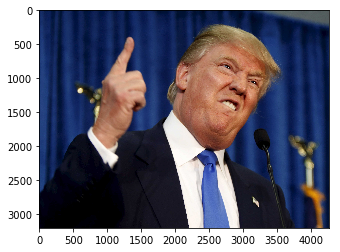

In [157]:
## Load test image
image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image.jpg')
#image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image_putin.jpg')
load_image = face_recognition.load_image_file(image_path)
imgplot = imshow(load_image)

In [158]:
## Facial Recognition classifier
list_encoding = face_recognition.face_encodings(load_image)
test_pred = face_names[np.array(clf.predict(list_encoding))]
print test_pred

['donald_trump']


In [3]:
import urllib, cStringIO
import scipy 
import pickle
import os
import numpy as np
import face_recognition

filename = os.path.join(os.environ['SHARED_OUTPUT_DIR'],'finalized_model.pkl')
clf = pickle.load( open(filename , "rb" ) )

filename = os.path.join(os.environ['SHARED_OUTPUT_DIR'],'face_names.pkl')
face_names = pickle.load(open(filename, 'rb'))

def recognition(params):
    """
    Loads an image url (.jpg, .png, etc) into a numpy array
    :param url: image url to load
    :return: face recognition over image url
    """
    image_file = cStringIO.StringIO(urllib.urlopen(params['url']).read())
    image = scipy.misc.imread(image_file, mode='RGB')
    # read the image file in a numpy array
    list_encoding = face_recognition.face_encodings(image)
    test_pred = []
    test_preds = []
    if list_encoding:
        for encoding in list_encoding:
            test_pred = face_names[clf.predict([encoding])][0]
            test_preds.append(test_pred)
    return list(test_preds)

print recognition({'url':'http://images.huffingtonpost.com/2017-02-11-1486846762-7068853-trump.jpg'})
print recognition({'url':'http://i2.cdn.turner.com/money/dam/assets/170122004138-snl-putin-780x439.jpeg'})

['donald_trump']
['other']
